# NBA Spread Form Analysis

## Objective
Analyze whether **recent spread coverage form** (performance over previous N games) predicts future spread coverage.

## Key Questions
1. Do teams in "good form" (covering spreads recently) continue to cover?
2. Do teams in "bad form" continue to fail to cover?
3. How does **opponent form** at matchup time affect outcomes?
4. Which rolling window (3, 5, 7) is most informative?
5. Does form predict 11-point handicap coverage specifically?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Config
CONFIG = {
    'sport': 'NBA',
    'windows': [3, 5, 7],
    'handicap': 11,
    'form_tiers': ['Cold', 'Neutral', 'Hot']
}

print(f"Form Analysis Config: {CONFIG}")

Form Analysis Config: {'sport': 'NBA', 'windows': [3, 5, 7], 'handicap': 11, 'form_tiers': ['Cold', 'Neutral', 'Hot']}


## Phase 1: Data Loading & Preparation

In [2]:
# Load NBA data
data_file = Path().resolve().parent / 'data' / 'results' / 'nba_season_results.xlsx'
df = pd.read_excel(data_file)

# Sort chronologically
df = df.sort_values('game_date').reset_index(drop=True)

print(f"Loaded {len(df)} NBA games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")

# Filter to games with spread data
df = df[df['spread_result_difference'].notna()].copy()
print(f"Games with spread data: {len(df)}")

# Get all teams
all_teams = set(df['home_team'].unique()) | set(df['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

df.head()

Loaded 537 NBA games
Date range: 2025-10-21 to 2026-01-05
Games with spread data: 537
Total teams: 30


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-10-21,Oklahoma City Thunder,Houston Rockets,-6.5,125,124,-5.5
1,2025-10-21,Los Angeles Lakers,Golden State Warriors,2.5,109,119,-7.5
2,2025-10-22,Orlando Magic,Miami Heat,-8.5,125,121,-4.5
3,2025-10-22,Atlanta Hawks,Toronto Raptors,-5.5,118,138,-25.5
4,2025-10-22,Chicago Bulls,Detroit Pistons,3.5,115,111,7.5


## Phase 2: Rolling Form Calculation

For each game, calculate each team's form going into that game based on their previous N games.

In [3]:
def calculate_team_form(games_df, windows=[3, 5, 7]):
    """
    For each game, calculate each team's form metrics based on their previous games.
    Returns a DataFrame with one row per team-game with form features.
    """
    games_sorted = games_df.sort_values('game_date').reset_index(drop=True)
    
    # Track each team's game history
    team_histories = defaultdict(list)
    
    # Results list
    form_records = []
    
    for idx, game in games_sorted.iterrows():
        game_date = game['game_date']
        home_team = game['home_team']
        away_team = game['away_team']
        spread_diff = game['spread_result_difference']
        
        # Calculate form for home team
        home_history = team_histories[home_team]
        home_form = calc_form_from_history(home_history, windows)
        
        # Calculate form for away team
        away_history = team_histories[away_team]
        away_form = calc_form_from_history(away_history, windows)
        
        # Determine outcomes
        home_covered = spread_diff >= 0
        away_covered = spread_diff < 0
        home_covered_handicap = spread_diff >= -CONFIG['handicap']
        away_covered_handicap = spread_diff <= CONFIG['handicap']
        
        # Create record for home team perspective
        home_record = {
            'game_idx': idx,
            'game_date': game_date,
            'team': home_team,
            'opponent': away_team,
            'is_home': True,
            'spread_diff': spread_diff,
            'did_cover': home_covered,
            'did_cover_handicap': home_covered_handicap,
            **{f'team_{k}': v for k, v in home_form.items()},
            **{f'opp_{k}': v for k, v in away_form.items()}
        }
        form_records.append(home_record)
        
        # Create record for away team perspective
        away_record = {
            'game_idx': idx,
            'game_date': game_date,
            'team': away_team,
            'opponent': home_team,
            'is_home': False,
            'spread_diff': -spread_diff,
            'did_cover': away_covered,
            'did_cover_handicap': away_covered_handicap,
            **{f'team_{k}': v for k, v in away_form.items()},
            **{f'opp_{k}': v for k, v in home_form.items()}
        }
        form_records.append(away_record)
        
        # Update histories
        team_histories[home_team].append({
            'date': game_date,
            'covered': home_covered,
            'margin': spread_diff
        })
        team_histories[away_team].append({
            'date': game_date,
            'covered': away_covered,
            'margin': -spread_diff
        })
    
    return pd.DataFrame(form_records)


def calc_form_from_history(history, windows):
    """
    Calculate form metrics from a team's game history.
    """
    form = {}
    
    n_games = len(history)
    form['games_played'] = n_games
    
    for w in windows:
        if n_games >= w:
            recent = history[-w:]
            covers = sum(1 for g in recent if g['covered'])
            margins = [g['margin'] for g in recent]
            
            form[f'covers_{w}'] = covers
            form[f'cover_pct_{w}'] = covers / w
            form[f'avg_margin_{w}'] = np.mean(margins)
        else:
            form[f'covers_{w}'] = np.nan
            form[f'cover_pct_{w}'] = np.nan
            form[f'avg_margin_{w}'] = np.nan
    
    # Calculate streak
    if n_games > 0:
        streak = 0
        last_result = history[-1]['covered']
        for g in reversed(history):
            if g['covered'] == last_result:
                streak += 1
            else:
                break
        form['streak'] = streak if last_result else -streak
    else:
        form['streak'] = 0
    
    return form


# Calculate form for all games
df_form = calculate_team_form(df, CONFIG['windows'])

print(f"Total team-game records: {len(df_form)}")
print(f"Columns: {list(df_form.columns)}")
df_form.head(10)

Total team-game records: 1074
Columns: ['game_idx', 'game_date', 'team', 'opponent', 'is_home', 'spread_diff', 'did_cover', 'did_cover_handicap', 'team_games_played', 'team_covers_3', 'team_cover_pct_3', 'team_avg_margin_3', 'team_covers_5', 'team_cover_pct_5', 'team_avg_margin_5', 'team_covers_7', 'team_cover_pct_7', 'team_avg_margin_7', 'team_streak', 'opp_games_played', 'opp_covers_3', 'opp_cover_pct_3', 'opp_avg_margin_3', 'opp_covers_5', 'opp_cover_pct_5', 'opp_avg_margin_5', 'opp_covers_7', 'opp_cover_pct_7', 'opp_avg_margin_7', 'opp_streak']


,game_idx,game_date,team,opponent,is_home,spread_diff,did_cover,did_cover_handicap,team_games_played,team_covers_3,team_cover_pct_3,team_avg_margin_3,team_covers_5,team_cover_pct_5,team_avg_margin_5,team_covers_7,team_cover_pct_7,team_avg_margin_7,team_streak,opp_games_played,opp_covers_3,opp_cover_pct_3,opp_avg_margin_3,opp_covers_5,opp_cover_pct_5,opp_avg_margin_5,opp_covers_7,opp_cover_pct_7,opp_avg_margin_7,opp_streak
0,0,2025-10-21,Oklahoma City Thunder,Houston Rockets,True,-5.5,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,0,2025-10-21,Houston Rockets,Oklahoma City Thunder,False,5.5,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1,2025-10-21,Los Angeles Lakers,Golden State Warriors,True,-7.5,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1,2025-10-21,Golden State Warriors,Los Angeles Lakers,False,7.5,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,2,2025-10-22,Orlando Magic,Miami Heat,True,-4.5,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
5,2,2025-10-22,Miami Heat,Orlando Magic,False,4.5,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
6,3,2025-10-22,Atlanta Hawks,Toronto Raptors,True,-25.5,False,False,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
7,3,2025-10-22,Toronto Raptors,Atlanta Hawks,False,25.5,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
8,4,2025-10-22,Chicago Bulls,Detroit Pistons,True,7.5,True,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
9,4,2025-10-22,Detroit Pistons,Chicago Bulls,False,-7.5,False,True,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


## Phase 3: Form Distribution Analysis

How often are teams in "hot" vs "cold" form?

Games with 5+ game history: 924


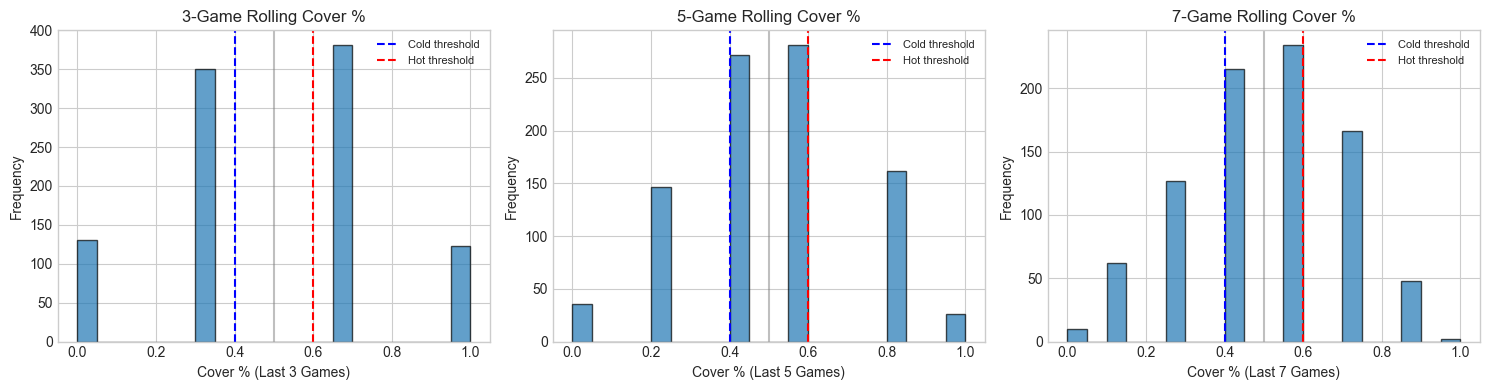


Form Tier Distribution (5-game window):
team_form_tier_5
Hot     469
Cold    455
Name: count, dtype: int64

Percentages:
team_form_tier_5
Hot     50.757576
Cold    49.242424
Name: count, dtype: float64


In [4]:
# Filter to games where form is calculable (enough previous games)
df_with_form = df_form[df_form['team_cover_pct_5'].notna()].copy()
print(f"Games with 5+ game history: {len(df_with_form)}")

# Classify form into tiers
def classify_form(pct):
    if pd.isna(pct):
        return 'Unknown'
    elif pct >= 0.6:
        return 'Hot'
    elif pct <= 0.4:
        return 'Cold'
    else:
        return 'Neutral'

for w in CONFIG['windows']:
    df_form[f'team_form_tier_{w}'] = df_form[f'team_cover_pct_{w}'].apply(classify_form)
    df_form[f'opp_form_tier_{w}'] = df_form[f'opp_cover_pct_{w}'].apply(classify_form)

# Form distribution visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for i, w in enumerate(CONFIG['windows']):
    ax = axes[i]
    col = f'team_cover_pct_{w}'
    data = df_form[df_form[col].notna()][col]
    
    ax.hist(data, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(x=0.4, color='blue', linestyle='--', label='Cold threshold')
    ax.axvline(x=0.6, color='red', linestyle='--', label='Hot threshold')
    ax.axvline(x=0.5, color='gray', linestyle='-', alpha=0.5)
    ax.set_xlabel(f'Cover % (Last {w} Games)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{w}-Game Rolling Cover %')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

# Form tier counts
print("\nForm Tier Distribution (5-game window):")
tier_counts = df_form[df_form['team_form_tier_5'] != 'Unknown']['team_form_tier_5'].value_counts()
print(tier_counts)
print(f"\nPercentages:")
print(tier_counts / tier_counts.sum() * 100)

## Phase 4: Form → Next Game Cover Analysis

**Key Question:** Do teams in good form continue to cover?

In [5]:
# Analyze cover rates by form tier
results = []

for w in CONFIG['windows']:
    tier_col = f'team_form_tier_{w}'
    df_valid = df_form[(df_form[tier_col] != 'Unknown') & (df_form[tier_col].notna())]
    
    for tier in ['Cold', 'Neutral', 'Hot']:
        tier_data = df_valid[df_valid[tier_col] == tier]
        n_games = len(tier_data)
        
        if n_games > 0:
            cover_rate = tier_data['did_cover'].mean() * 100
            handicap_rate = tier_data['did_cover_handicap'].mean() * 100
            avg_margin = tier_data['spread_diff'].mean()
            
            results.append({
                'window': w,
                'form_tier': tier,
                'n_games': n_games,
                'cover_rate': cover_rate,
                'handicap_cover_rate': handicap_rate,
                'avg_margin': avg_margin
            })

df_results = pd.DataFrame(results)

print("Form → Next Game Cover Rate")
print("="*70)
print(df_results.to_string(index=False))

Form → Next Game Cover Rate
 window form_tier  n_games  cover_rate  handicap_cover_rate  avg_margin
      3      Cold      480   47.500000            78.333333   -1.063542
      3       Hot      504   51.984127            80.753968    0.973214
      5      Cold      455   48.791209            78.241758   -0.609890
      5       Hot      469   51.385928            81.449893    0.631130
      7      Cold      199   46.733668            72.864322   -1.680905
      7   Neutral      449   49.220490            80.623608    0.023385
      7       Hot      216   54.166667            84.259259    1.527778


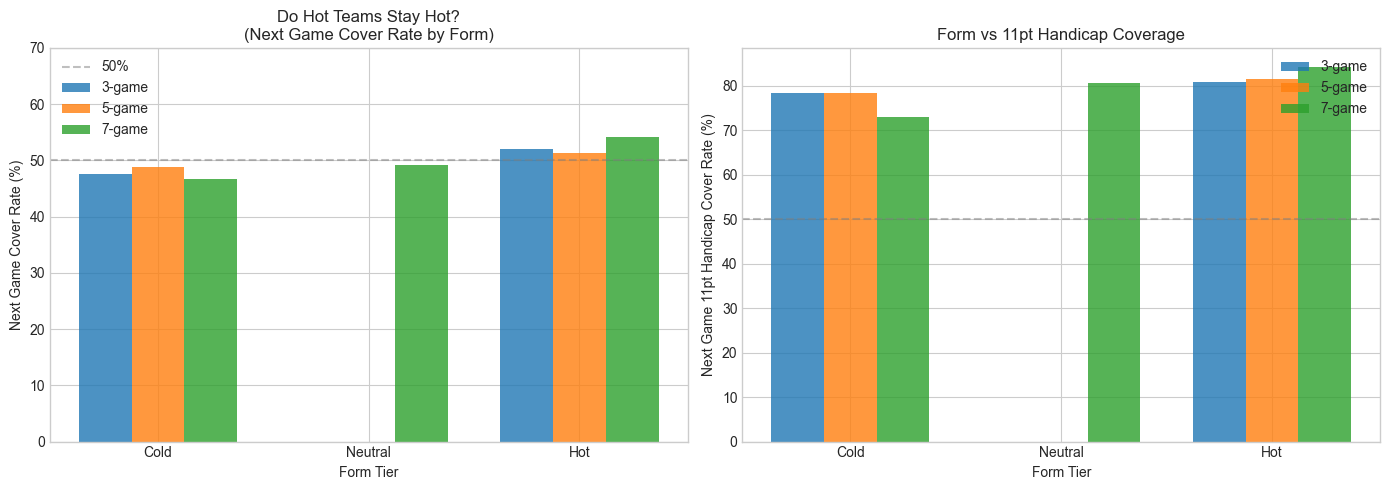

In [6]:
# Helper function to safely get rate
def get_rate(df_w, tier, col):
    subset = df_w[df_w['form_tier'] == tier]
    if len(subset) > 0:
        return subset[col].values[0]
    return np.nan

# Visualize form → cover rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: Cover rate by form tier and window
ax = axes[0]
x = np.arange(3)
width = 0.25

for i, w in enumerate(CONFIG['windows']):
    df_w = df_results[df_results['window'] == w]
    rates = [get_rate(df_w, t, 'cover_rate') for t in ['Cold', 'Neutral', 'Hot']]
    ax.bar(x + i*width, rates, width, label=f'{w}-game', alpha=0.8)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='50%')
ax.set_xticks(x + width)
ax.set_xticklabels(['Cold', 'Neutral', 'Hot'])
ax.set_ylabel('Next Game Cover Rate (%)')
ax.set_xlabel('Form Tier')
ax.set_title('Do Hot Teams Stay Hot?\n(Next Game Cover Rate by Form)')
ax.legend()
ax.set_ylim(0, 70)

# Same for handicap coverage
ax = axes[1]
for i, w in enumerate(CONFIG['windows']):
    df_w = df_results[df_results['window'] == w]
    rates = [get_rate(df_w, t, 'handicap_cover_rate') for t in ['Cold', 'Neutral', 'Hot']]
    ax.bar(x + i*width, rates, width, label=f'{w}-game', alpha=0.8)

ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_xticks(x + width)
ax.set_xticklabels(['Cold', 'Neutral', 'Hot'])
ax.set_ylabel(f'Next Game {CONFIG["handicap"]}pt Handicap Cover Rate (%)')
ax.set_xlabel('Form Tier')
ax.set_title(f'Form vs {CONFIG["handicap"]}pt Handicap Coverage')
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# Analyze extreme form (very hot / very cold)
print("\nExtreme Form Analysis (5-game window)")
print("="*70)

df_5 = df_form[df_form['team_cover_pct_5'].notna()].copy()

# Very hot: 4+ covers in last 5 (80%+)
very_hot = df_5[df_5['team_cover_pct_5'] >= 0.8]
print(f"\nVery Hot (80%+ in last 5): {len(very_hot)} instances")
if len(very_hot) > 0:
    print(f"  Next game cover rate: {very_hot['did_cover'].mean()*100:.1f}%")
    print(f"  Next game {CONFIG['handicap']}pt cover rate: {very_hot['did_cover_handicap'].mean()*100:.1f}%")
    print(f"  Avg spread margin: {very_hot['spread_diff'].mean():.2f}")

# Very cold: 0-1 covers in last 5 (20% or less)
very_cold = df_5[df_5['team_cover_pct_5'] <= 0.2]
print(f"\nVery Cold (20%- in last 5): {len(very_cold)} instances")
if len(very_cold) > 0:
    print(f"  Next game cover rate: {very_cold['did_cover'].mean()*100:.1f}%")
    print(f"  Next game {CONFIG['handicap']}pt cover rate: {very_cold['did_cover_handicap'].mean()*100:.1f}%")
    print(f"  Avg spread margin: {very_cold['spread_diff'].mean():.2f}")

# Perfect form: 5/5 covers
perfect = df_5[df_5['team_cover_pct_5'] == 1.0]
print(f"\nPerfect Form (5/5 covers): {len(perfect)} instances")
if len(perfect) > 0:
    print(f"  Next game cover rate: {perfect['did_cover'].mean()*100:.1f}%")
    print(f"  (Regression to mean expected at ~50%)")


Extreme Form Analysis (5-game window)

Very Hot (80%+ in last 5): 188 instances
  Next game cover rate: 45.7%
  Next game 11pt cover rate: 78.2%
  Avg spread margin: -0.84

Very Cold (20%- in last 5): 183 instances
  Next game cover rate: 47.5%
  Next game 11pt cover rate: 77.6%
  Avg spread margin: -2.02

Perfect Form (5/5 covers): 26 instances
  Next game cover rate: 34.6%
  (Regression to mean expected at ~50%)


## Phase 5: Form vs Opponent Form Matrix

**Key Question:** Does opponent form matter?

In [8]:
# Create form vs opponent form matrix (using 5-game window)
w = 5
df_matrix = df_form[
    (df_form[f'team_form_tier_{w}'] != 'Unknown') & 
    (df_form[f'opp_form_tier_{w}'] != 'Unknown') &
    (df_form[f'team_form_tier_{w}'].notna()) &
    (df_form[f'opp_form_tier_{w}'].notna())
].copy()

print(f"Games with both team and opponent form: {len(df_matrix)}")

# Create matrix
tier_order = ['Cold', 'Neutral', 'Hot']
matrix_cover = pd.DataFrame(index=tier_order, columns=tier_order, dtype=float)
matrix_handicap = pd.DataFrame(index=tier_order, columns=tier_order, dtype=float)
matrix_n = pd.DataFrame(index=tier_order, columns=tier_order, dtype=int)

for team_tier in tier_order:
    for opp_tier in tier_order:
        mask = (df_matrix[f'team_form_tier_{w}'] == team_tier) & (df_matrix[f'opp_form_tier_{w}'] == opp_tier)
        subset = df_matrix[mask]
        n = len(subset)
        matrix_n.loc[team_tier, opp_tier] = n
        if n > 0:
            matrix_cover.loc[team_tier, opp_tier] = subset['did_cover'].mean() * 100
            matrix_handicap.loc[team_tier, opp_tier] = subset['did_cover_handicap'].mean() * 100

print("\nCover Rate Matrix (Team Form vs Opponent Form)")
print("Rows = Team Form, Columns = Opponent Form")
print(matrix_cover.round(1))

print("\nSample Sizes:")
print(matrix_n)

Games with both team and opponent form: 916

Cover Rate Matrix (Team Form vs Opponent Form)
Rows = Team Form, Columns = Opponent Form
         Cold  Neutral   Hot
Cold     50.0      NaN  47.1
Neutral   NaN      NaN   NaN
Hot      52.9      NaN  50.0

Sample Sizes:
          Cold  Neutral    Hot
Cold     222.0      0.0  227.0
Neutral    0.0      0.0    0.0
Hot      227.0      0.0  240.0


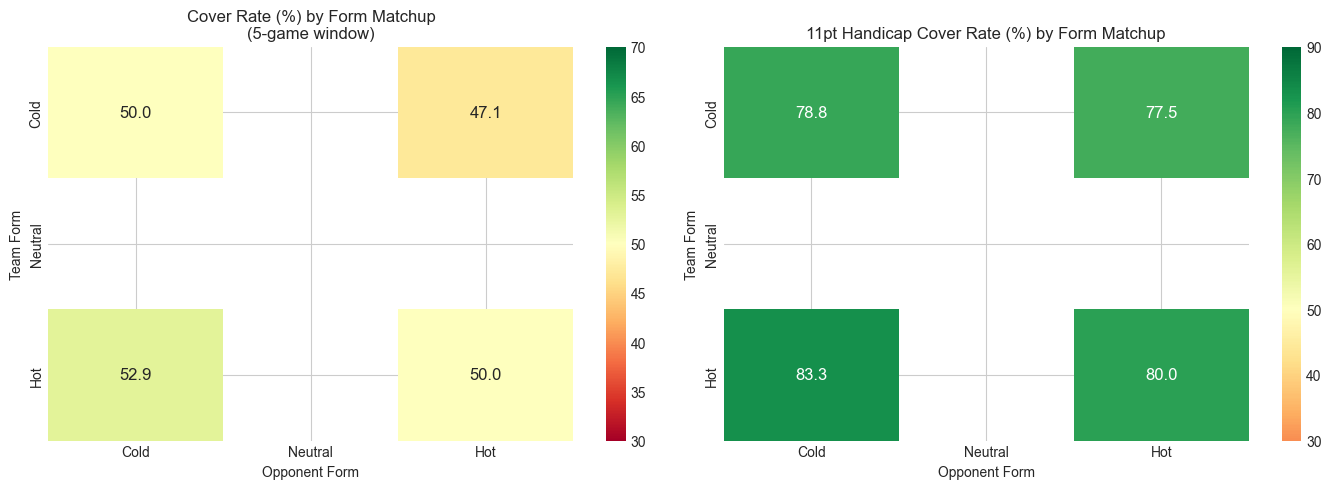

In [9]:
# Visualize the matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cover rate heatmap
ax = axes[0]
sns.heatmap(matrix_cover.astype(float), annot=True, fmt='.1f', cmap='RdYlGn', 
            center=50, ax=ax, vmin=30, vmax=70,
            annot_kws={'size': 12})
ax.set_xlabel('Opponent Form')
ax.set_ylabel('Team Form')
ax.set_title('Cover Rate (%) by Form Matchup\n(5-game window)')

# Handicap cover rate heatmap
ax = axes[1]
sns.heatmap(matrix_handicap.astype(float), annot=True, fmt='.1f', cmap='RdYlGn', 
            center=50, ax=ax, vmin=30, vmax=90,
            annot_kws={'size': 12})
ax.set_xlabel('Opponent Form')
ax.set_ylabel('Team Form')
ax.set_title(f'{CONFIG["handicap"]}pt Handicap Cover Rate (%) by Form Matchup')

plt.tight_layout()
plt.show()

In [10]:
# Key matchup insights
print("\nKey Matchup Insights (5-game window)")
print("="*70)

# Hot vs Cold
hot_vs_cold = df_matrix[(df_matrix['team_form_tier_5'] == 'Hot') & (df_matrix['opp_form_tier_5'] == 'Cold')]
cold_vs_hot = df_matrix[(df_matrix['team_form_tier_5'] == 'Cold') & (df_matrix['opp_form_tier_5'] == 'Hot')]

print(f"\nHot team vs Cold opponent: {len(hot_vs_cold)} games")
if len(hot_vs_cold) > 0:
    print(f"  Cover rate: {hot_vs_cold['did_cover'].mean()*100:.1f}%")
    print(f"  {CONFIG['handicap']}pt handicap rate: {hot_vs_cold['did_cover_handicap'].mean()*100:.1f}%")

print(f"\nCold team vs Hot opponent: {len(cold_vs_hot)} games")
if len(cold_vs_hot) > 0:
    print(f"  Cover rate: {cold_vs_hot['did_cover'].mean()*100:.1f}%")
    print(f"  {CONFIG['handicap']}pt handicap rate: {cold_vs_hot['did_cover_handicap'].mean()*100:.1f}%")

# Form differential
df_matrix['form_diff'] = df_matrix['team_cover_pct_5'] - df_matrix['opp_cover_pct_5']
corr_cover = df_matrix['form_diff'].corr(df_matrix['did_cover'].astype(float))
corr_handicap = df_matrix['form_diff'].corr(df_matrix['did_cover_handicap'].astype(float))

print(f"\nForm Differential Correlation:")
print(f"  Form diff vs Cover: {corr_cover:.3f}")
print(f"  Form diff vs {CONFIG['handicap']}pt Handicap Cover: {corr_handicap:.3f}")


Key Matchup Insights (5-game window)

Hot team vs Cold opponent: 227 games
  Cover rate: 52.9%
  11pt handicap rate: 83.3%

Cold team vs Hot opponent: 227 games
  Cover rate: 47.1%
  11pt handicap rate: 77.5%

Form Differential Correlation:
  Form diff vs Cover: 0.011
  Form diff vs 11pt Handicap Cover: 0.015


## Phase 6: 11-Point Handicap Form Analysis

In [11]:
# Compare predictive power: raw cover vs handicap cover
print(f"Form → Handicap Coverage Analysis ({CONFIG['handicap']}pt cushion)")
print("="*70)

df_5 = df_form[df_form['team_cover_pct_5'].notna()].copy()

# Overall handicap rate
overall_handicap_rate = df_5['did_cover_handicap'].mean() * 100
print(f"\nOverall {CONFIG['handicap']}pt handicap cover rate: {overall_handicap_rate:.1f}%")

# By form tier
print(f"\nHandicap Cover Rate by Form Tier (5-game window):")
for tier in ['Cold', 'Neutral', 'Hot']:
    tier_data = df_5[df_5['team_form_tier_5'] == tier]
    if len(tier_data) > 0:
        hcap_rate = tier_data['did_cover_handicap'].mean() * 100
        cover_rate = tier_data['did_cover'].mean() * 100
        lift = hcap_rate - overall_handicap_rate
        print(f"  {tier:8s}: {hcap_rate:5.1f}% ({'+' if lift > 0 else ''}{lift:.1f}% vs avg) | Raw cover: {cover_rate:.1f}%")

Form → Handicap Coverage Analysis (11pt cushion)

Overall 11pt handicap cover rate: 79.9%

Handicap Cover Rate by Form Tier (5-game window):
  Cold    :  78.2% (-1.6% vs avg) | Raw cover: 48.8%
  Hot     :  81.4% (+1.6% vs avg) | Raw cover: 51.4%


In [12]:
# Continuous relationship: form % → handicap cover rate
df_5 = df_form[df_form['team_cover_pct_5'].notna()].copy()

# Bin by form percentage
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
df_5['form_bin'] = pd.cut(df_5['team_cover_pct_5'], bins=bins, labels=labels, include_lowest=True)

# Calculate rates by bin
bin_stats = df_5.groupby('form_bin').agg({
    'did_cover': ['mean', 'count'],
    'did_cover_handicap': 'mean',
    'spread_diff': 'mean'
}).round(3)
bin_stats.columns = ['cover_rate', 'n_games', 'handicap_rate', 'avg_margin']
bin_stats['cover_rate'] *= 100
bin_stats['handicap_rate'] *= 100

print("\nCover Rates by Form Bin (5-game window):")
print(bin_stats)


Cover Rates by Form Bin (5-game window):
          cover_rate  n_games  handicap_rate  avg_margin
form_bin                                                
0-20%           47.5      183           77.6      -2.019
20-40%          49.6      272           78.7       0.338
40-60%          55.2      281           83.6       1.616
60-80%          47.5      162           80.2      -0.213
80-100%         34.6       26           65.4      -4.750


/var/folders/jv/y3m0xwm544l00560wd0v47gh0000gn/T/ipykernel_7742/2582604545.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_stats = df_5.groupby('form_bin').agg({


## Phase 7: Streak Analysis

In [13]:
# Streak analysis
print("Streak Analysis")
print("="*70)

df_streak = df_form[df_form['team_streak'].notna()].copy()

# Group by streak length
streak_groups = {
    '3+ cover streak': df_streak[df_streak['team_streak'] >= 3],
    '2 cover streak': df_streak[df_streak['team_streak'] == 2],
    '1 cover': df_streak[df_streak['team_streak'] == 1],
    '1 non-cover': df_streak[df_streak['team_streak'] == -1],
    '2 non-cover streak': df_streak[df_streak['team_streak'] == -2],
    '3+ non-cover streak': df_streak[df_streak['team_streak'] <= -3]
}

print(f"\n{'Streak Type':<22} | {'N Games':>8} | {'Cover %':>8} | {'Handicap %':>10}")
print("-"*60)

for name, data in streak_groups.items():
    if len(data) > 0:
        cover_pct = data['did_cover'].mean() * 100
        hcap_pct = data['did_cover_handicap'].mean() * 100
        print(f"{name:<22} | {len(data):>8} | {cover_pct:>7.1f}% | {hcap_pct:>9.1f}%")

Streak Analysis

Streak Type            |  N Games |  Cover % | Handicap %
------------------------------------------------------------
3+ cover streak        |      123 |    51.2% |      77.2%
2 cover streak         |      132 |    48.5% |      75.8%
1 cover                |      267 |    50.9% |      81.3%
1 non-cover            |      270 |    52.6% |      83.3%
2 non-cover streak     |      122 |    44.3% |      77.9%
3+ non-cover streak    |      130 |    48.5% |      77.7%


## Summary: Key Findings

In [14]:
print("="*70)
print("NBA SPREAD FORM ANALYSIS: KEY FINDINGS")
print("="*70)

print(f"\n1. DATA SUMMARY")
print(f"   - Total games analyzed: {len(df)}")
print(f"   - Team-game records with 5+ game history: {len(df_5)}")

# Form → Cover relationship
print(f"\n2. FORM → COVER RELATIONSHIP (5-game window)")
hot_cover = df_5[df_5['team_form_tier_5'] == 'Hot']['did_cover'].mean() * 100
cold_cover = df_5[df_5['team_form_tier_5'] == 'Cold']['did_cover'].mean() * 100
print(f"   - Hot teams next-game cover rate: {hot_cover:.1f}%")
print(f"   - Cold teams next-game cover rate: {cold_cover:.1f}%")
print(f"   - Difference: {hot_cover - cold_cover:.1f}pp")

# Handicap coverage
print(f"\n3. {CONFIG['handicap']}PT HANDICAP FORM ANALYSIS")
hot_hcap = df_5[df_5['team_form_tier_5'] == 'Hot']['did_cover_handicap'].mean() * 100
cold_hcap = df_5[df_5['team_form_tier_5'] == 'Cold']['did_cover_handicap'].mean() * 100
print(f"   - Hot teams handicap cover rate: {hot_hcap:.1f}%")
print(f"   - Cold teams handicap cover rate: {cold_hcap:.1f}%")
print(f"   - Difference: {hot_hcap - cold_hcap:.1f}pp")

# Opponent form impact
print(f"\n4. OPPONENT FORM IMPACT")
print(f"   - Form differential correlation with cover: {corr_cover:.3f}")

# Extreme form
print(f"\n5. EXTREME FORM OUTCOMES")
if len(very_hot) > 0:
    print(f"   - Very hot (80%+) → next game cover: {very_hot['did_cover'].mean()*100:.1f}% ({len(very_hot)} games)")
if len(very_cold) > 0:
    print(f"   - Very cold (20%-) → next game cover: {very_cold['did_cover'].mean()*100:.1f}% ({len(very_cold)} games)")

print(f"\n6. ACTIONABLE INSIGHTS")
if hot_cover > 52:
    print(f"   - Hot teams show positive momentum (+{hot_cover - 50:.1f}% vs baseline)")
elif hot_cover < 48:
    print(f"   - Hot teams show regression to mean ({hot_cover - 50:.1f}% vs baseline)")
else:
    print(f"   - Hot teams show no significant edge ({hot_cover:.1f}% ≈ baseline)")

if cold_cover > 52:
    print(f"   - Cold teams bounce back (+{cold_cover - 50:.1f}% vs baseline)")
elif cold_cover < 48:
    print(f"   - Cold teams stay cold ({cold_cover - 50:.1f}% vs baseline)")
else:
    print(f"   - Cold teams show no significant pattern ({cold_cover:.1f}% ≈ baseline)")

NBA SPREAD FORM ANALYSIS: KEY FINDINGS

1. DATA SUMMARY
   - Total games analyzed: 537
   - Team-game records with 5+ game history: 924

2. FORM → COVER RELATIONSHIP (5-game window)
   - Hot teams next-game cover rate: 51.4%
   - Cold teams next-game cover rate: 48.8%
   - Difference: 2.6pp

3. 11PT HANDICAP FORM ANALYSIS
   - Hot teams handicap cover rate: 81.4%
   - Cold teams handicap cover rate: 78.2%
   - Difference: 3.2pp

4. OPPONENT FORM IMPACT
   - Form differential correlation with cover: 0.011

5. EXTREME FORM OUTCOMES
   - Very hot (80%+) → next game cover: 45.7% (188 games)
   - Very cold (20%-) → next game cover: 47.5% (183 games)

6. ACTIONABLE INSIGHTS
   - Hot teams show no significant edge (51.4% ≈ baseline)
   - Cold teams show no significant pattern (48.8% ≈ baseline)


In [15]:
# Export form data for further analysis
export_file = Path().resolve().parent / 'data' / 'results' / 'nba_spread_form_analysis.csv'
df_form.to_csv(export_file, index=False)
print(f"Exported form data to: {export_file}")

# Summary table
print("\nForm → Cover Rate Summary Table:")
print(df_results.pivot(index='form_tier', columns='window', values='cover_rate').round(1))

Exported form data to: /Users/robertbatchelor/Documents/Projects/sports-betting/backend/data/results/nba_spread_form_analysis.csv

Form → Cover Rate Summary Table:
window        3     5     7
form_tier                  
Cold       47.5  48.8  46.7
Hot        52.0  51.4  54.2
Neutral     NaN   NaN  49.2
